## 2.5 Sarsaで迷路を攻略

- 贪婪法，采用Q值最大的动作
- 我们将以一定的概率ε随机行动，在剩下的1-ε概率下采用动作价值Q最大的行动。这种方法称为ε-贪婪法。
    - 随着试验次数（回合数或轮数）的增加，ε值会渐渐减小。

In [31]:
# 使用するパッケージの宣言
import numpy as np
import matplotlib.pyplot as plt


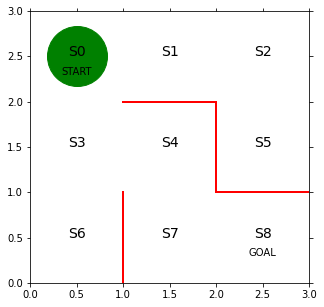

In [32]:
# 初期位置での迷路の様子

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 状態を示す文字S0～S8を描く
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 描画範囲の設定と目盛りを消す設定
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 現在地S0に緑丸を描画する
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)


In [33]:
# 初期の方策を決定するパラメータtheta_0を設定

# 行は状態0～7、列は移動方向で↑、→、↓、←を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8はゴールなので、方策はなし
                    ])

In [34]:
# 将策略参数theta_0转换为随机策略

def simple_convert_into_pi_from_theta(theta):
    '''简单计算比率'''

    [m, n] = theta.shape  # thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 割合の計算

    pi = np.nan_to_num(pi)  # nanを0に変換

    return pi

# 求取随机动作采取策略pi_0
pi_0 = simple_convert_into_pi_from_theta(theta_0)


In [36]:
# 设置初始的动作价值函数

[a, b] = theta_0.shape  # 行と列の数をa, bに格納
Q = np.random.rand(a, b) * theta_0
# 将theya_0乘到各元素上, 使得Q的墙壁方向的值为nan, x * nan == nan
print(theta_0.shape)
print(Q)

(8, 4)
[[  nan 0.424 0.845   nan]
 [  nan 0.492   nan 0.243]
 [  nan   nan 0.284 0.562]
 [0.509 0.214 0.32    nan]
 [  nan   nan 0.958 0.46 ]
 [0.034   nan   nan   nan]
 [0.083   nan   nan   nan]
 [0.686 0.163   nan   nan]]


In [38]:
# ε-greedy法实现

def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 确定行动
    if np.random.rand() < epsilon:
        # 以ε概率随机行动
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # 采用Q的最大值对应的动作
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 动作a对应的方向
    
    # 由动作确定下一个状态
    if next_direction == "up":
        s_next = s - 3  # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 3  # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next


贝尔曼方程：

$Q(s_t,a_t) = R_{t+1} + \gamma Q(S_{t+1},a_{t+1})$

In [42]:
# Sarsaによる行動価値関数Qの更新
# 基于Sarsa更新动作价值函数 Q
# 当时间差TD变为0时，则已经正确学习到了动作价值函数

def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):
#     print(s,a,s_next,a_next)
    if s_next == 8:  # 到达目标, 不存在[s_next, a_next]了
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

    return Q


In [43]:
# Sarsaで迷路を解く関数の定義、状態と行動の履歴および更新したQを出力
# 定义基于Sarasa求解迷宫问题的函数, 输出状态, 动作的历史记录和更新后的Q

def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # start_point
    a = a_next = get_action(s, Q, epsilon, pi)  # 初始动作 ε-greedy法实现, 随机或者最大值, according to 策略pi
    s_a_history = [[0, np.nan]]  # 记录智能体的移动序列

    while (1):  # 循环直到到达目标
        a = a_next  # 更新动作
        s_a_history[-1][1] = a
        # 将动作放在现在的状态下(最终的index=-1)

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 有效的下一个状态
        s_a_history.append([s_next, np.nan])
        # 代入下一个状态, 动作未知用nan

        # 给予奖励, 求得下一个动作
        if s_next == 8:
            r = 1  # 到达目标, 给予奖励
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi) 
            # 获得下一个动作a_next

        # 更新价值函数
        # 状态, 动作, 即时奖励, 下一个状态, 下一个动作, Q, eta, gamma
        Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)

        # 终止判断
        if s_next == 8:  # 到达end point
            break
        else:
            s = s_next

    return [s_a_history, Q]


In [44]:
# 通过Sarsa求解迷宫问题

eta = 0.1  # 学習率
gamma = 0.9  # 时间折扣率
epsilon = 0.5  # ε-greedy法的初始值
v = np.nanmax(Q, axis=1)  # 根据状态求价值的最大
print("Q:\n",Q)
print("V:\n",v)
is_continue = True
episode = 1

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("当前回合:" + str(episode))

    # ε-greedy的值逐渐减少
    epsilon = epsilon / 2

    # 通过Sarsa求解迷宫问题, 求取移动历史和更新后的Q值
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状态价值的变化
    new_v = np.nanmax(Q, axis=1)  # 各状态求得最大价值
    print(np.sum(np.abs(new_v - v)))  # 输出状态价值的变化
    v = new_v

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 重复100回合
    episode = episode + 1
    if episode > 100:
        break


Q:
 [[  nan 0.313 0.725   nan]
 [  nan 0.312   nan 0.31 ]
 [  nan   nan 0.239 0.311]
 [0.331 0.809 0.235   nan]
 [  nan   nan 0.9   0.342]
 [0.105   nan   nan   nan]
 [0.244   nan   nan   nan]
 [0.35  1.      nan   nan]]
V:
 [0.725 0.312 0.311 0.809 0.9   0.105 0.244 1.   ]
当前回合:1
0.04529897094308777
迷路を解くのにかかったステップ数は6です
当前回合:2
0.008372225780910236
迷路を解くのにかかったステップ数は4です
当前回合:3
0.007122918778750709
迷路を解くのにかかったステップ数は4です
当前回合:4
0.0060396080386337925
迷路を解くのにかかったステップ数は4です
当前回合:5
0.005101600206769752
迷路を解くのにかかったステップ数は4です
当前回合:6
0.004290679500593031
迷路を解くのにかかったステップ数は4です
当前回合:7
0.0035908192271513206
迷路を解くのにかかったステップ数は4です
当前回合:8
0.002987926213655845
迷路を解くのにかかったステップ数は4です
当前回合:9
0.0024696144532730946
迷路を解くのにかかったステップ数は4です
当前回合:10
0.0020250046794503263
迷路を解くのにかかったステップ数は4です
当前回合:11
0.0019524221202661396
迷路を解くのにかかったステップ数は4です
当前回合:12
0.001919043516275476
迷路を解くのにかかったステップ数は4です
当前回合:13
0.0018728899859942194
迷路を解くのにかかったステップ数は4です
当前回合:14
0.0018168435087343449
迷路を解くのにかかったステップ数は4です
当前回合:15
0.001753338039863661

In [15]:
np.set_printoptions(precision=3, suppress=True)  # 设置有效位数为3, 不显示指数
print(Q)

[[  nan 0.181 0.729   nan]
 [  nan 0.18    nan 0.18 ]
 [  nan   nan 0.18  0.18 ]
 [0.196 0.81  0.29    nan]
 [  nan   nan 0.9   0.296]
 [0.179   nan   nan   nan]
 [0.335   nan   nan   nan]
 [0.083 1.      nan   nan]]


In [29]:
# エージェントの移動の様子を可視化します
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 3) + 0.5  # 状態のx座標は、3で割った余り+0.5
    y = 2.5 - int(state / 3)  # y座標は3で割った商を2.5から引く
    line.set_data(x, y)
    return (line,)


#　初期化関数とフレームごとの描画関数を用いて動画を作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(
    s_a_history), interval=200, repeat=False)

HTML(anim.to_jshtml())